In [1]:
ct = '../data/2018_2008.tsv'
scores = '../out/ko_scores_s288c.txt'
old1 = '../out/hillenmeyer2008/lscores.tsv'
old2 = '../out/hillenmeyer2008/zscores.tsv'
old3 = '../out/hillenmeyer2008/pvalues.tsv'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
# other imports
import random
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
d = {}
for b, h1, h2, h in pd.read_table(ct).values:
    if str(h2) == 'nan':
        h2 = None
    else:
        h2 = str(int(h2))
    d[b] = (h1, h2)

In [5]:
m = pd.read_table(scores, index_col=0).loc['S288C'].reset_index()
m['condition'] = [x.lower()
                  for x in m['condition']]
m['signed-qvalue'] = [np.sign(x) * -np.log10(y)
                      for x,y in m[['score', 'qvalue']].values]
m['phenotype'] = [1 if x is True
                  else 0 for x in m['qvalue'] < 0.05]
m = m.set_index(['condition', 'gene'])
m.sort_index(inplace=True)
o1 = pd.read_table(old1, index_col=0)
o1.index = [x.split(':')[0] for x in o1.index]
# o2 = pd.read_table(old2, index_col=0)
# o2.index = [x.split(':')[0] for x in o2.index]
o3 = pd.read_table(old3, index_col=0)
o3.index = [x.split(':')[0] for x in o3.index]
o1 = o1.stack()
o1.name = 'log-ratio'
o3 = o3.stack()
o3.name = 'p-value'
o = o1.to_frame().join(o3.to_frame())
o = o.swaplevel()
o = o.sort_index()
o['signed-pvalue'] = [np.sign(x) * -np.log10(y)
                      for x,y in o[['log-ratio', 'p-value']].values]
o['phenotype'] = [1 if x is True
                  else 0 for x in o['p-value'] < np.power(10., -5)]

In [6]:
cs = {}
for b, (h1, h2) in d.items():
    if h2 is None:
        c = sorted({x[0] for x in o.index
                    if x[0].split(':')[1] == h1})
    else:
        c = sorted({x[0] for x in o.index
                    if x[0].split(':')[1] == h1
                    and x[0].split(':')[2] == h2})
    cs[b] = c

In [7]:
res = []
for b, hs in cs.items():
    for h in hs:
        x = m.loc[b]['score']
        x = x[~x.index.duplicated()].dropna()
        y = o.loc[h]['log-ratio']
        y.index.name = 'gene'
        y = y[~y.index.duplicated()].dropna()
        idx = sorted(set(x.index).intersection(y.index))
        r1, p1 = stats.pearsonr(x.loc[idx],
                                y.loc[idx])
        x = m.loc[b]['signed-qvalue']
        x = x[~x.index.duplicated()].dropna()
        y = o.loc[h]['signed-pvalue']
        y.index.name = 'gene'
        y = y[~y.index.duplicated()].dropna()
        idx = sorted(set(x.index).intersection(y.index))
        r2, p2 = stats.pearsonr(x.loc[idx],
                                y.loc[idx])
        x = m.loc[b]['phenotype']
        x = x[~x.index.duplicated()].dropna()
        y = o.loc[h]['phenotype']
        y.index.name = 'gene'
        y = y[~y.index.duplicated()].dropna()
        idx = sorted(set(x.index).intersection(y.index))
        x = x.loc[idx]
        y = y.loc[idx]
        r3 = y[x == 1].sum() / x[x == 1].shape[0]
        r4 = x[y == 1].sum() / y[y == 1].shape[0]
        res.append((b, h,
                    len(m[m['qvalue'] < 0.05].loc[b].index.intersection(idx)),
                    len(idx), r1, p1,
                              r2, p2,
                              r3, r4))
r = pd.DataFrame(res,
                 columns=['2018',
                          '2008',
                          'phenotypes',
                          'genes',
                          'r-score',
                          'pval-score',
                          'r-significance',
                          'pval-significance',
                          'recall2018',
                          'recall2008'])

/nfs/leia/research/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


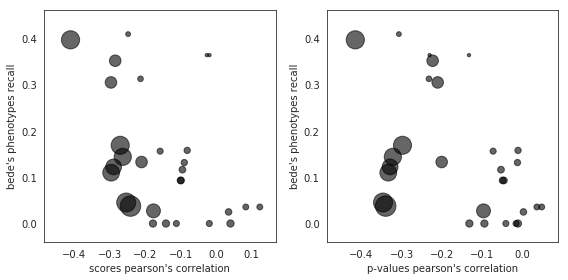

In [8]:
plt.figure(figsize=(8, 4))

plt.subplot(121)

plt.scatter(r['r-score'],
            r['recall2018'],
            s=r['phenotypes'],
            color='k',
            alpha=0.6)

plt.xlabel('scores pearson\'s correlation')
plt.ylabel('bede\'s phenotypes recall')

plt.subplot(122)

plt.scatter(r['r-significance'],
            r['recall2018'],
            s=r['phenotypes'],
            color='k',
            alpha=0.6)

plt.xlabel('p-values pearson\'s correlation')
plt.ylabel('bede\'s phenotypes recall')

plt.tight_layout();

<h5><a href="javascript:toggle()" target="_self">toggle source code</a></h5>